In [664]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [665]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [666]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])

        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1) + 0.00002*(t.rand(6)-0.5) # Add noises

        return state

In [667]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [668]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, n):
        super(Simulation, self).__init__()
        self.T = T
        self.state = self.initialize_state(n)
        self.controller = controller
        self.dynamics = dynamics
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state,n):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state,n)

    @staticmethod
    def initialize_state(n):
        print('ini',n)
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print('Generate %d initial states of rocket:' % n)
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state, n):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.]) # weight of each state
        return states.sum(dim=0)/n

In [669]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.1, line_search_fn='strong_wolfe')

    def step(self,n):
        def closure():
            loss = self.simulation(self.simulation.state,n)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch, n):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        print('Start Training:')
        while error > eps and epoch <= max_epoch:
            loss = self.step(n)
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.6f' % (epoch, loss))
            error = loss.item()
            cord = self.visualize()
        # print('Landing Trajectory:')
        # for r in range(n):
        #     plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
        #     plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
        #     plt.plot(w1, h, color="red", linewidth=3)
        #     plt.plot(w2, h, color="green", linewidth=3)
        #     plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

In [670]:
class Evaluation:
    def __init__(self, simulation):
        self.simulation = simulation

    def test(self, n):
        print('Start Testing:')
        loss = self.simulation(self.simulation.state,n)
        print('loss: %.6f' % loss)
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print('Landing Trajectory:')
        for r in range(n):
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
            plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
            plt.show()
            end = data[-1,r,:]
            print(np.abs(end))

ini 200
Generate 200 initial states of rocket:
[[ 1.10380031e-01 -1.09893125e-03  1.41958196e-01 -1.33200566e-02
   1.36542095e+00 -8.36445522e-02]
 [ 2.40028384e-01  4.99990068e-02  2.00618882e-01  4.72694720e-02
   1.49729754e+00 -5.93883853e-02]
 [-3.24616499e-01  1.36784889e-01  6.23113096e-04 -9.54927686e-03
   1.11541490e+00 -4.79843940e-02]
 ...
 [ 3.31982099e-01  1.53784861e-01 -4.80889496e-02  7.73989551e-03
   1.26526089e+00 -2.51780971e-02]
 [-8.76394565e-02 -1.28482713e-01  1.49064200e-01  1.86127348e-02
   1.33580160e+00 -5.07695333e-02]
 [-9.93222103e-02  1.38367871e-01 -2.65280493e-01  6.99331132e-03
   1.02058085e+00 -3.84533226e-02]]
Start Training:
[1] loss: 0.695731


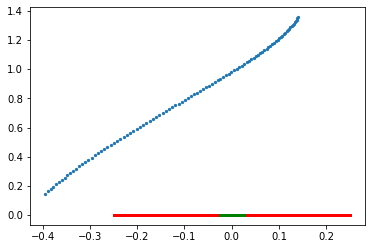

[2] loss: 0.037108


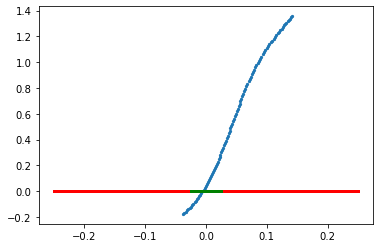

[3] loss: 0.014648


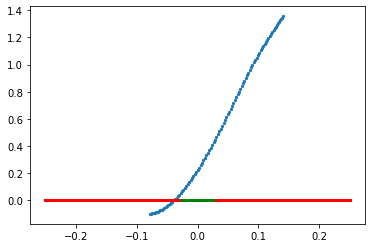

[4] loss: 0.002476


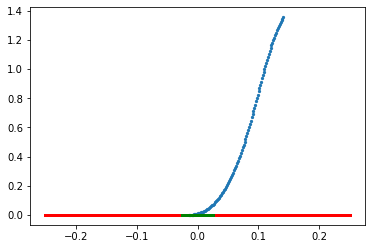

[5] loss: 0.001559


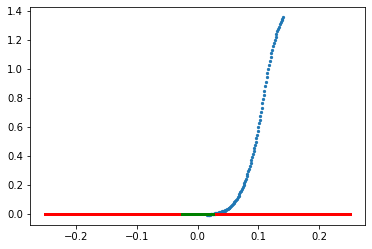

[6] loss: 0.000991


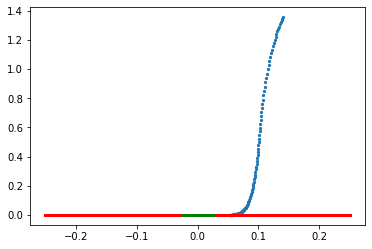

[7] loss: 0.000724


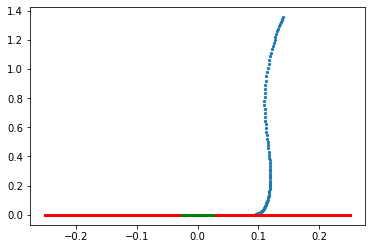

[8] loss: 0.000585


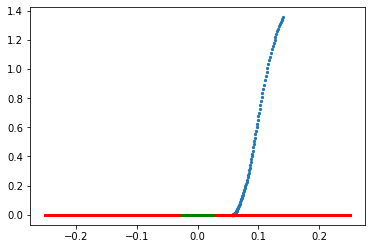

[9] loss: 0.000454


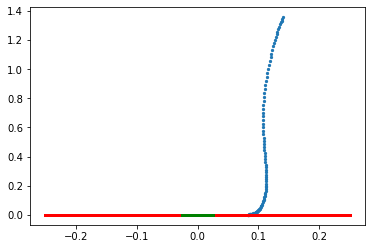

[10] loss: 0.000264


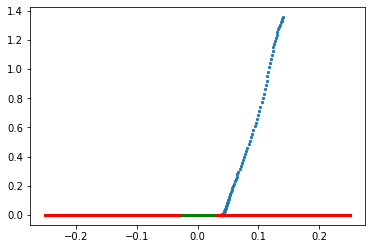

[11] loss: 0.000212


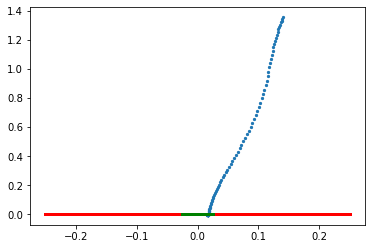

[12] loss: 0.000155


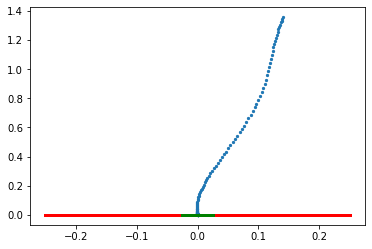

[13] loss: 0.000126


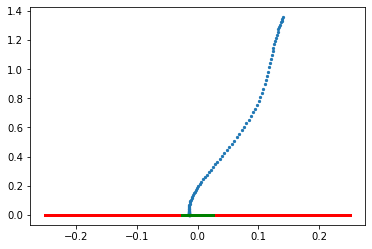

[14] loss: 0.000101


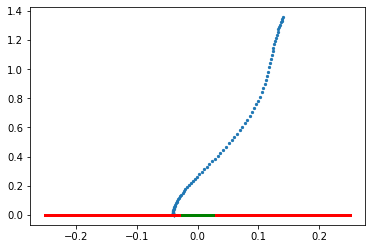

[15] loss: 0.000085


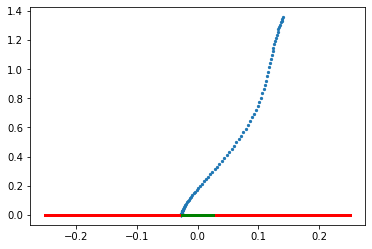

[16] loss: 0.000076


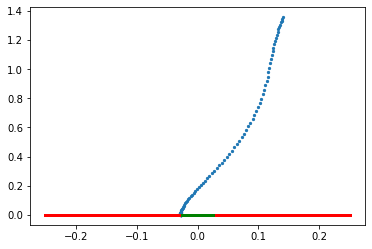

[17] loss: 0.000074


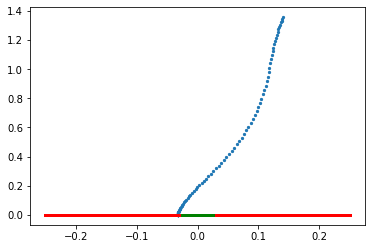

[18] loss: 0.000071


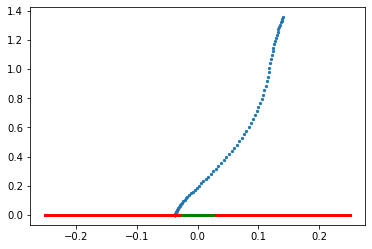

[19] loss: 0.000064


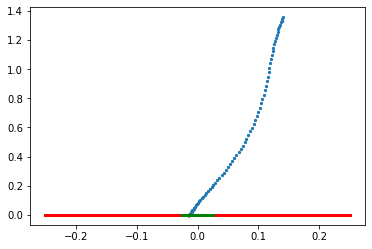

[20] loss: 0.000060


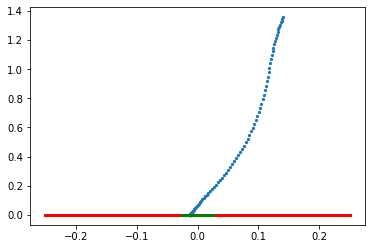

[21] loss: 0.000058


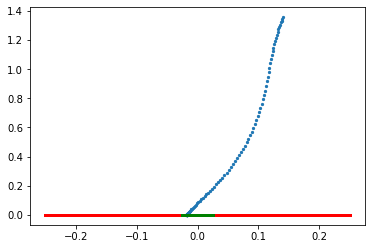

[22] loss: 0.000057


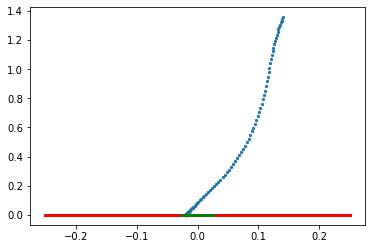

[23] loss: 0.000057


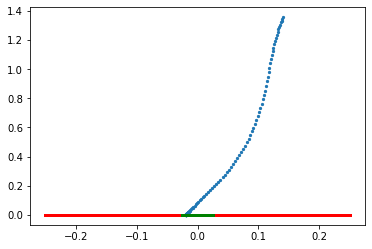

[24] loss: 0.000057


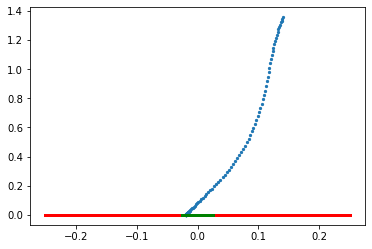

[25] loss: 0.000057


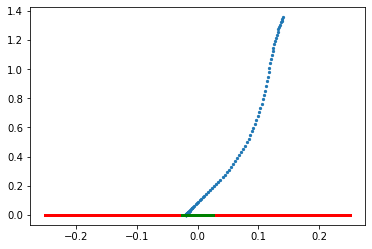

[26] loss: 0.000057


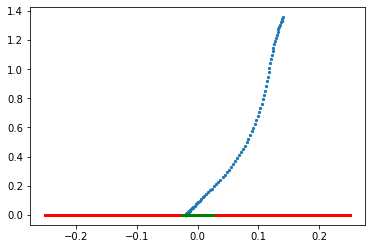

[27] loss: 0.000057


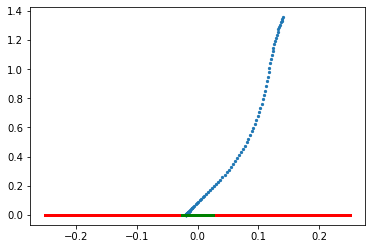

[28] loss: 0.000057


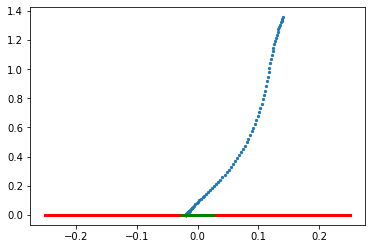

[29] loss: 0.000057


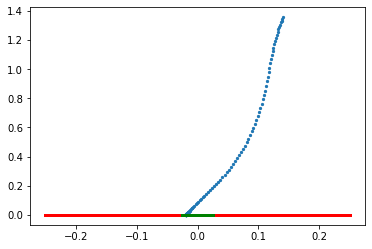

[30] loss: 0.000057


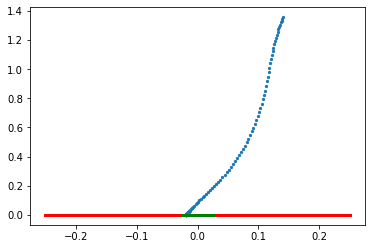

[31] loss: 0.000057


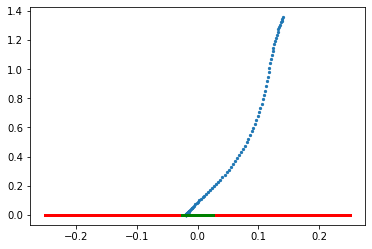

[32] loss: 0.000057


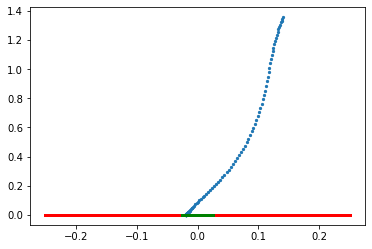

[33] loss: 0.000057


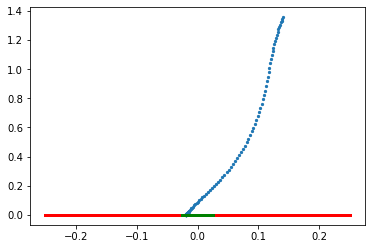

[34] loss: 0.000057


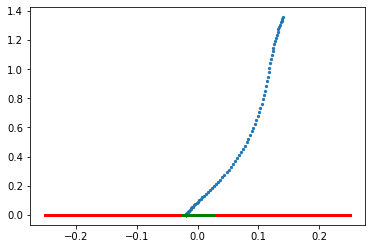

[35] loss: 0.000057


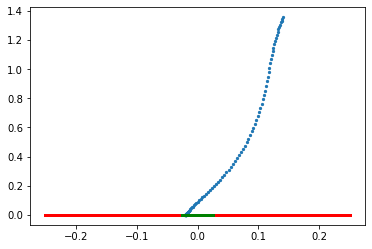

[36] loss: 0.000057


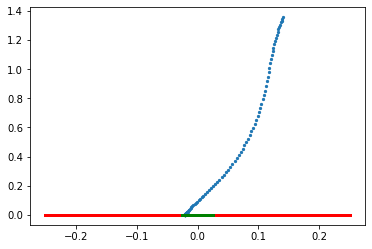

[37] loss: 0.000056


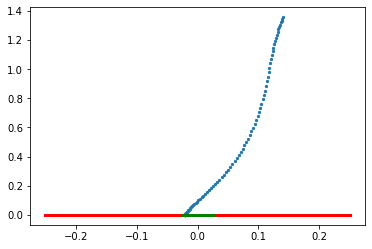

[38] loss: 0.000056


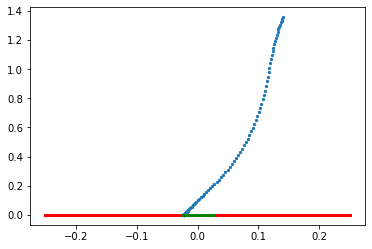

[39] loss: 0.000056


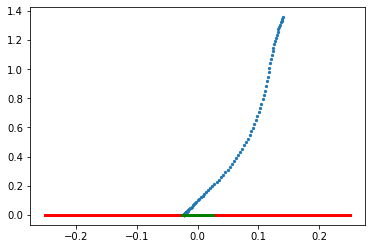

[40] loss: 0.000056


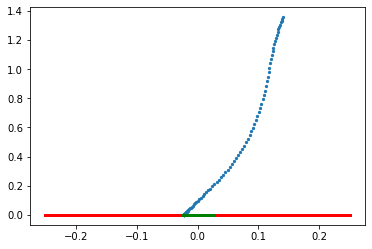

[41] loss: 0.000055


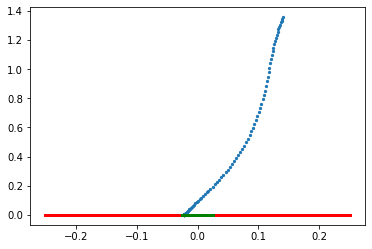

[42] loss: 0.000054


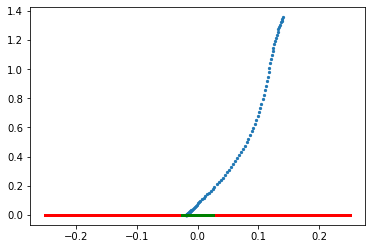

[43] loss: 0.000053


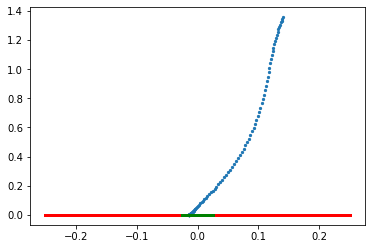

[44] loss: 0.000053


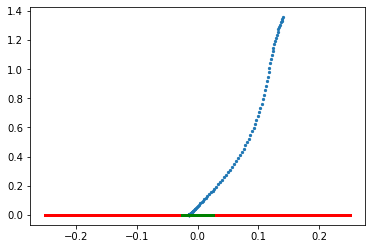

[45] loss: 0.000053


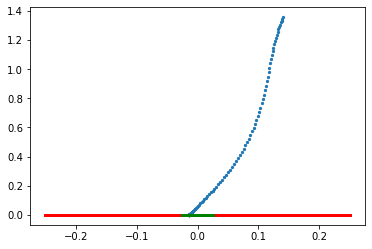

[46] loss: 0.000053


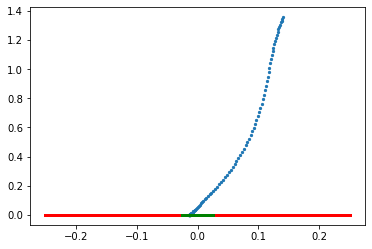

[47] loss: 0.000053


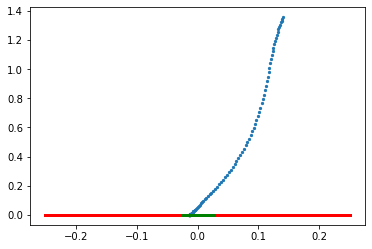

[48] loss: 0.000053


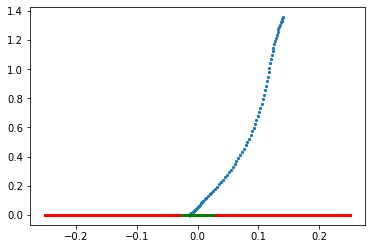

[49] loss: 0.000053


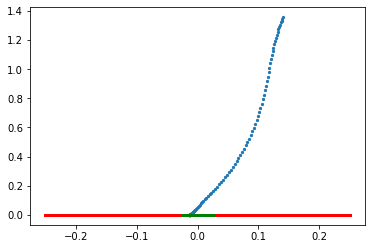

[50] loss: 0.000053


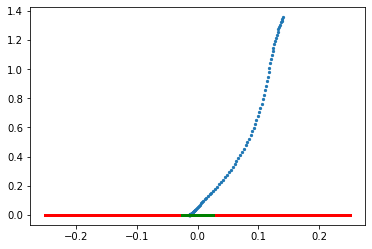

[51] loss: 0.000053


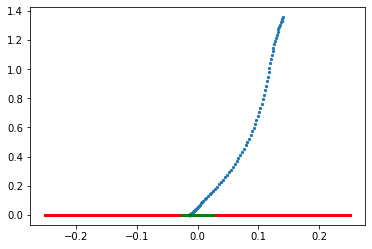

[52] loss: 0.000053


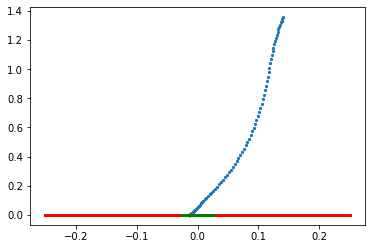

[53] loss: 0.000052


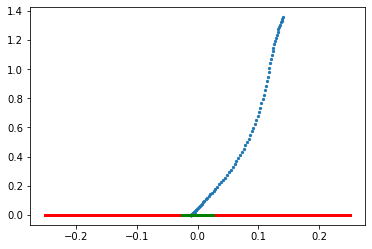

[54] loss: 0.000052


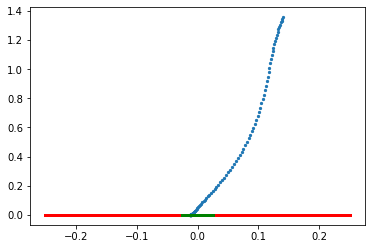

[55] loss: 0.000050


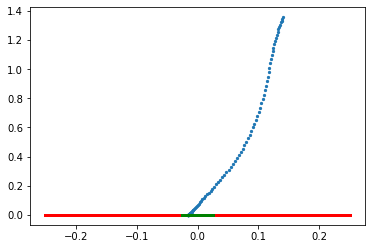

[56] loss: 0.000049


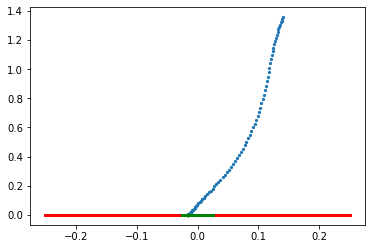

[57] loss: 0.000049


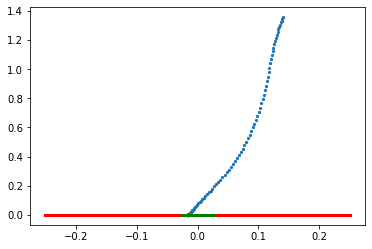

[58] loss: 0.000048


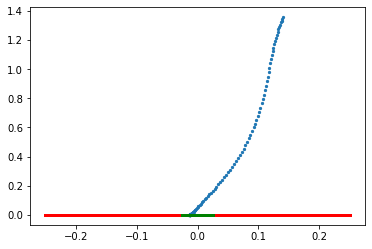

[59] loss: 0.000048


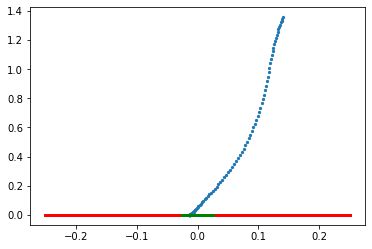

[60] loss: 0.000048


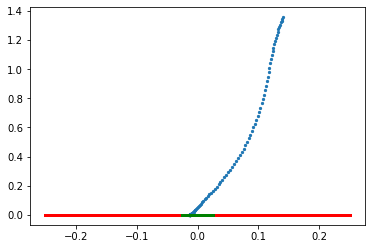

[61] loss: 0.000048


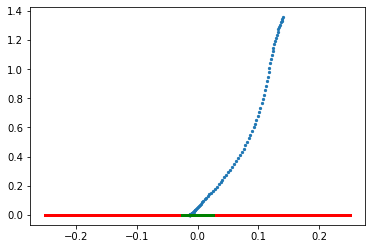

[62] loss: 0.000048


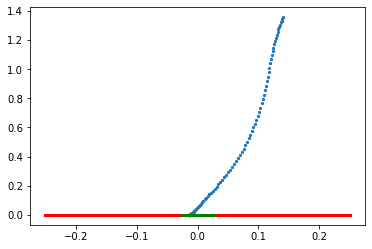

[63] loss: 0.000048


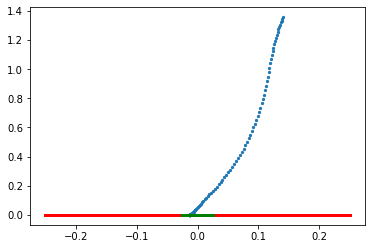

[64] loss: 0.000048


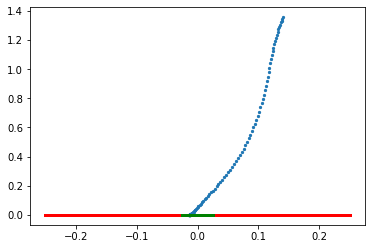

[65] loss: 0.000048


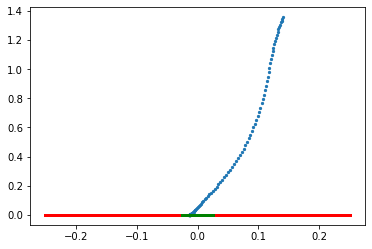

[66] loss: 0.000048


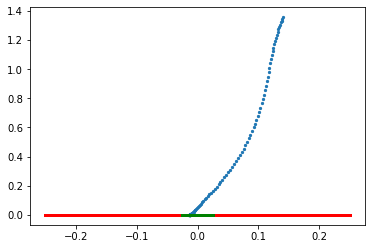

[67] loss: 0.000047


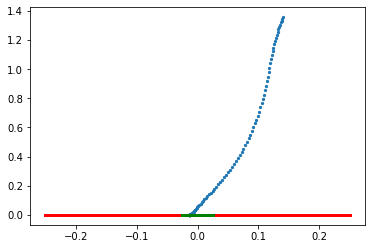

[68] loss: 0.000047


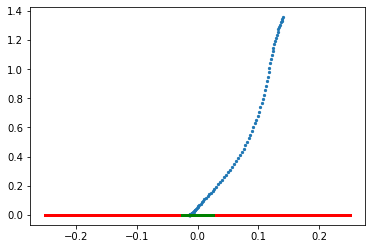

[69] loss: 0.000048


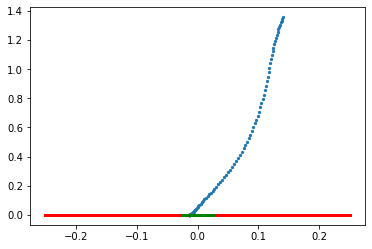

[70] loss: 0.000047


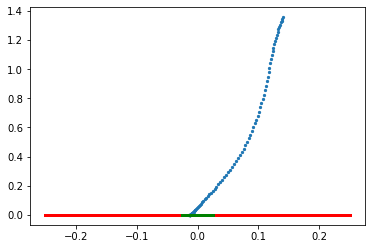

[71] loss: 0.000047


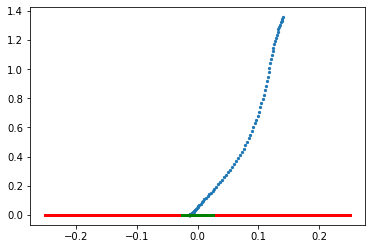

[72] loss: 0.000047


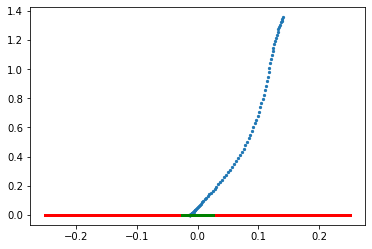

[73] loss: 0.000047


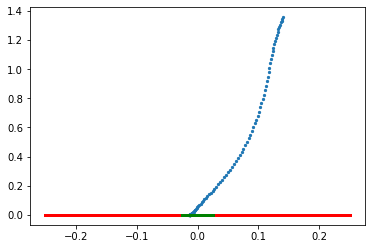

[74] loss: 0.000047


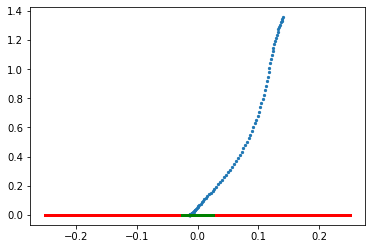

[75] loss: 0.000047


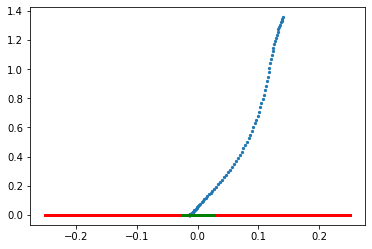

[76] loss: 0.000047


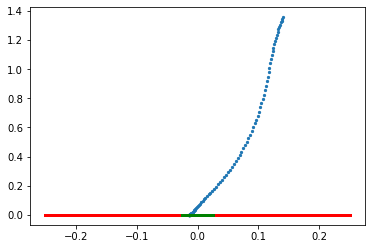

[77] loss: 0.000047


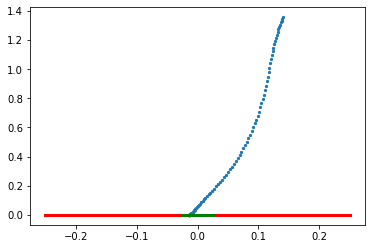

[78] loss: 0.000047


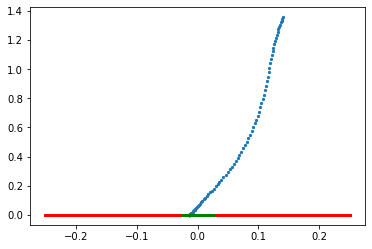

[79] loss: 0.000046


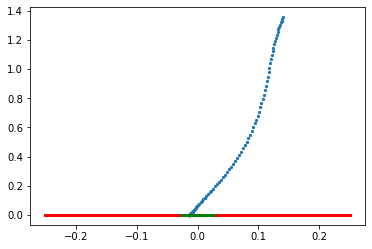

[80] loss: 0.000046


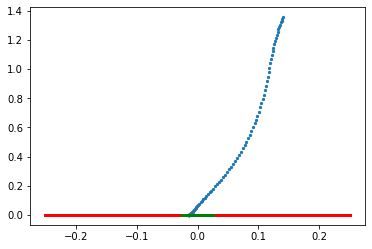

[81] loss: 0.000046


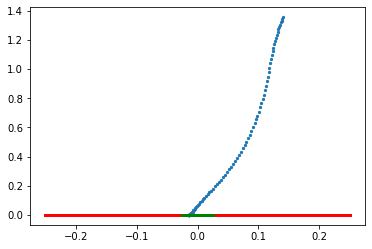

[82] loss: 0.000043


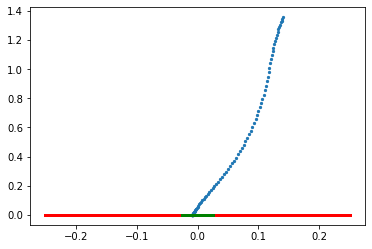

[83] loss: 0.000042


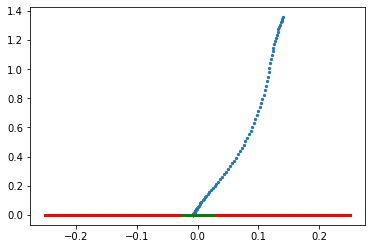

[84] loss: 0.000039


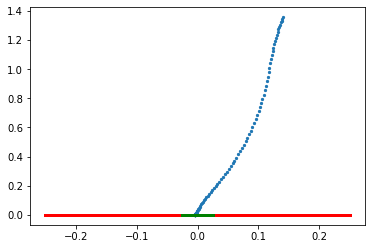

[85] loss: 0.000039


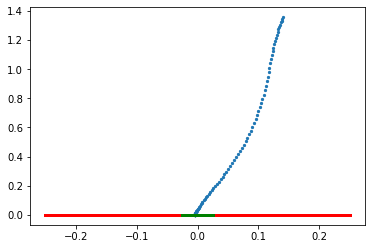

[86] loss: 0.000039


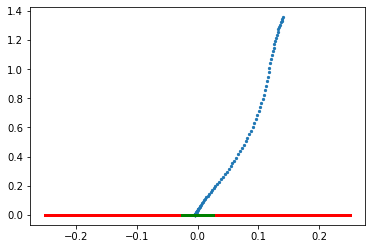

[87] loss: 0.000039


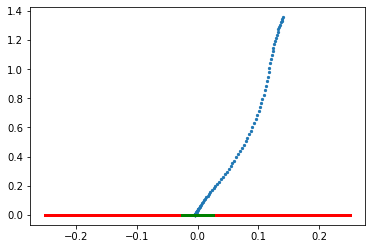

[88] loss: 0.000039


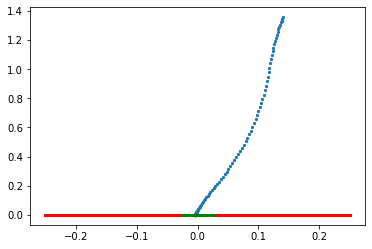

[89] loss: 0.000038


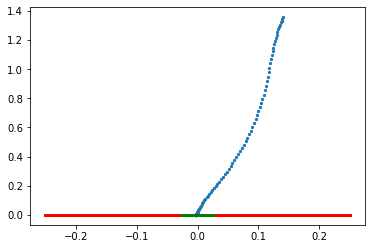

[90] loss: 0.000038


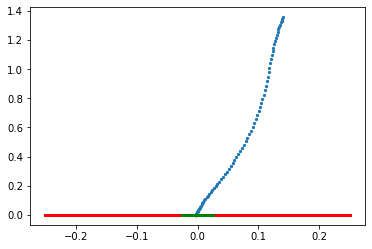

[91] loss: 0.000038


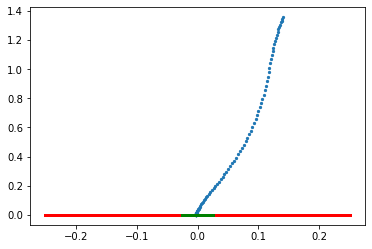

[92] loss: 0.000038


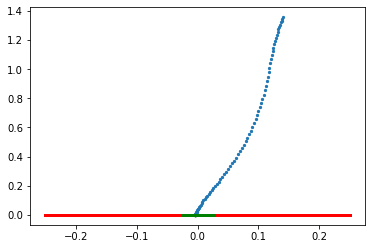

[93] loss: 0.000038


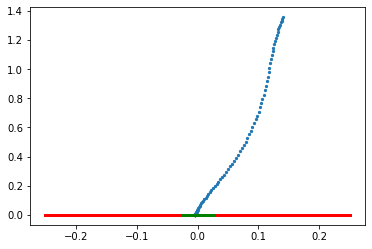

[94] loss: 0.000038


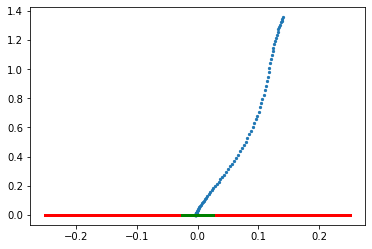

[95] loss: 0.000038


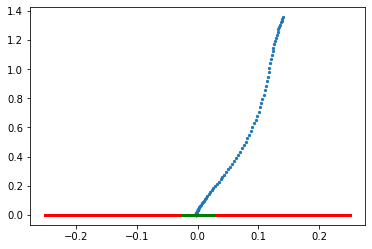

[96] loss: 0.000037


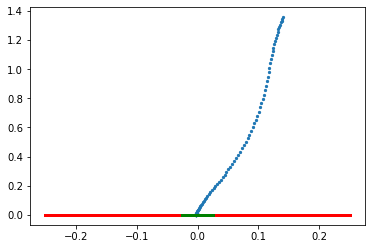

[97] loss: 0.000037


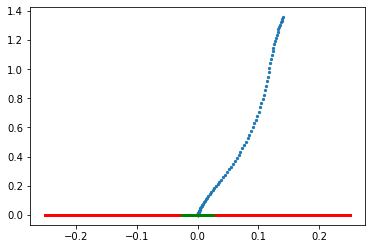

[98] loss: 0.000037


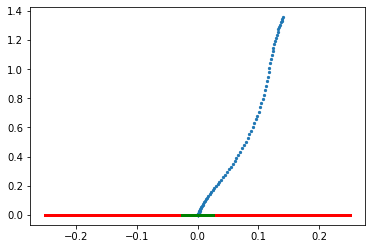

[99] loss: 0.000036


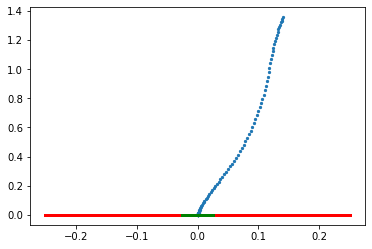

[100] loss: 0.000036


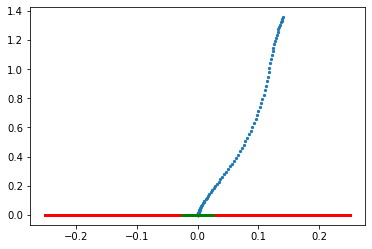

[101] loss: 0.000036


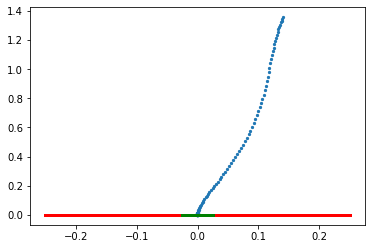

[102] loss: 0.000036


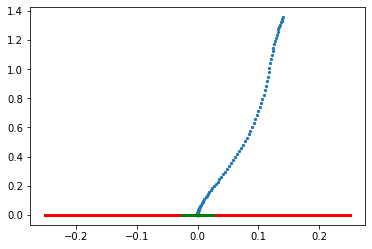

[103] loss: 0.000036


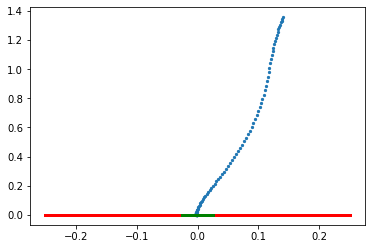

[104] loss: 0.000034


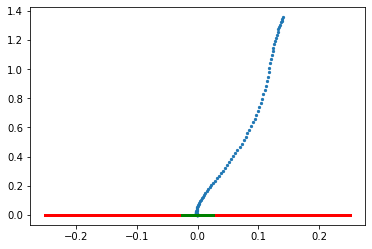

[105] loss: 0.000034


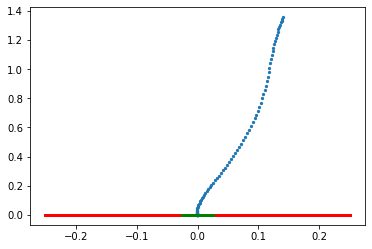

[106] loss: 0.000033


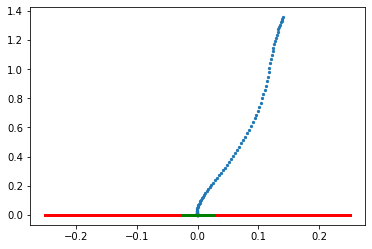

[107] loss: 0.000032


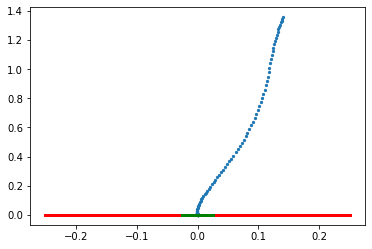

[108] loss: 0.000032


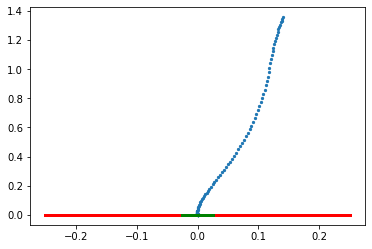

[109] loss: 0.000031


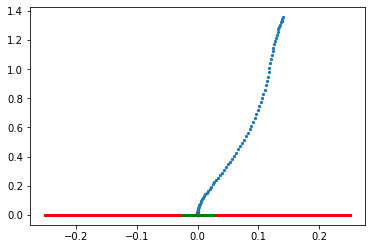

[110] loss: 0.000031


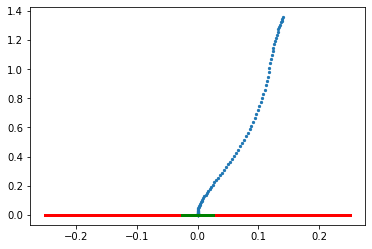

[111] loss: 0.000031


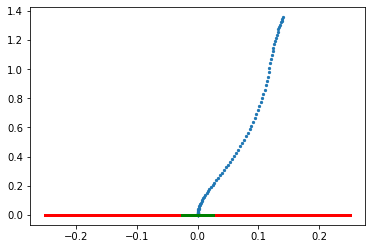

[112] loss: 0.000030


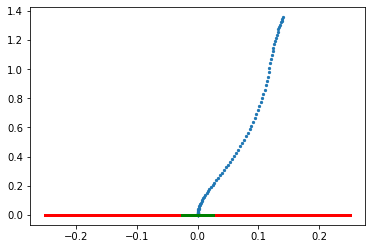

[113] loss: 0.000030


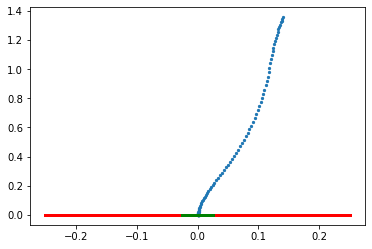

[114] loss: 0.000029


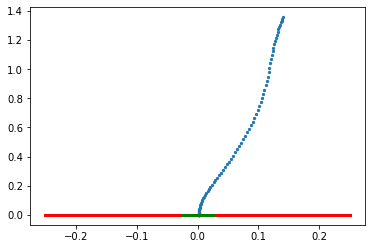

[115] loss: 0.000028


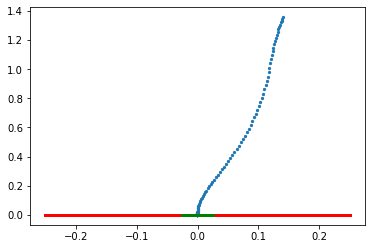

[116] loss: 0.000026


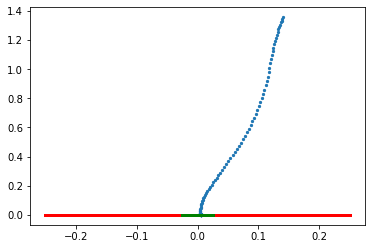

[117] loss: 0.000026


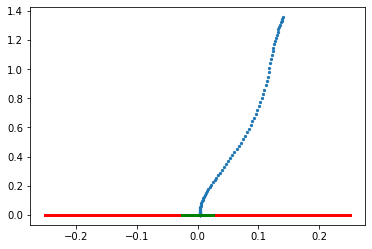

[118] loss: 0.000025


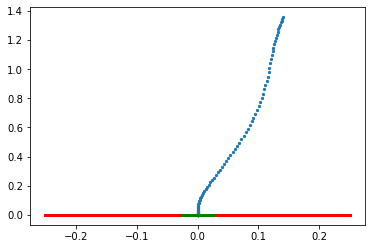

[119] loss: 0.000023


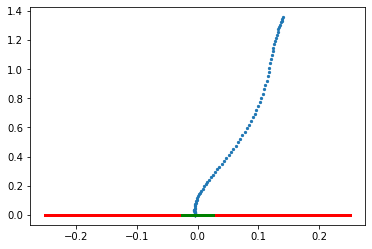

[120] loss: 0.000023


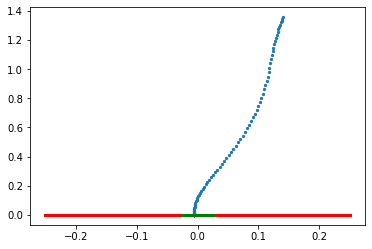

[121] loss: 0.000022


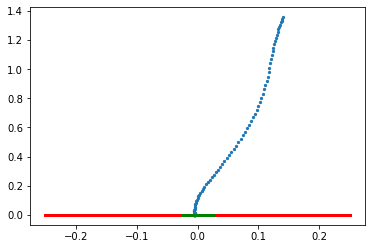

Convergence Plot:


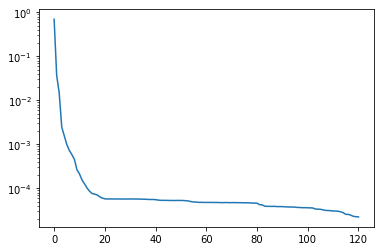

In [671]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 200  # number of initial states
err = 0.00001 # acceptable_error
itr = 120 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err,itr,N)  # solve the optimization problem

path = './Landing_Model.pth' # save model
t.save(c.state_dict(),path)

10
ini 10
Generate 10 initial states of rocket:
[[-4.80119629e-01 -1.02951768e-01 -3.30350988e-01  2.88231253e-02
   1.46712407e+00 -1.88028899e-02]
 [-7.32171002e-01 -1.44981448e-01  4.29164584e-02 -2.65278404e-02
   1.23162601e+00 -7.91611143e-04]
 [ 4.68174559e-01  1.29460180e-01  3.17169462e-01 -4.52831287e-02
   1.24794681e+00 -7.67956578e-02]
 [-8.14321094e-02 -1.01977757e-01  2.33742776e-01  1.29899782e-02
   1.32671722e+00 -4.38144390e-02]
 [ 5.03083029e-01  3.47029035e-02 -1.80718223e-01  3.33361064e-02
   1.44634738e+00 -8.44967551e-02]
 [ 4.56719649e-01 -2.64608514e-02  3.61024277e-01 -6.63836347e-03
   1.30669364e+00 -1.05620583e-02]
 [-4.89800436e-01 -5.33663029e-02  4.15112591e-01 -8.67982075e-03
   1.15709878e+00 -7.93455360e-02]
 [-4.94496396e-01 -5.81463731e-02 -3.84789739e-01  4.94484112e-03
   1.01040059e+00 -5.40645507e-02]
 [-4.84114805e-01 -1.12524878e-01  2.77873874e-01  4.34063048e-02
   1.17161331e+00 -3.90382145e-02]
 [ 1.37592705e-01 -1.38643463e-01 -4.707845

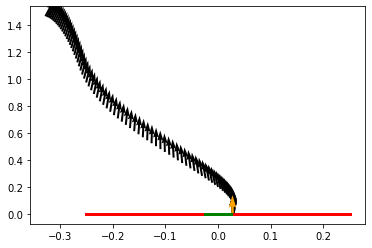

[7.4139854e-04 6.5890013e-04 2.7475424e-02 8.0524996e-04 1.8944567e-05
 4.7799430e-04]


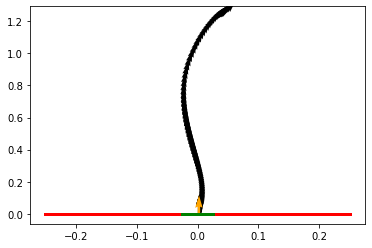

[2.5308901e-03 2.1319306e-03 2.1664321e-03 5.4879341e-04 7.9426027e-05
 5.1572220e-04]


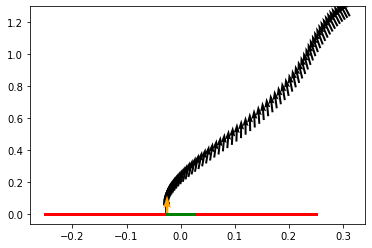

[0.00055971 0.00052433 0.02521981 0.0002978  0.00051506 0.0002244 ]


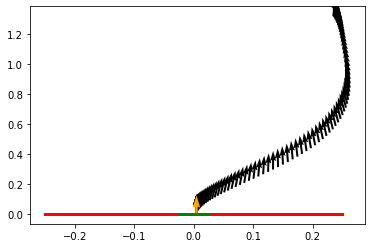

[0.00097619 0.00118318 0.00445382 0.00047809 0.00104599 0.00101883]


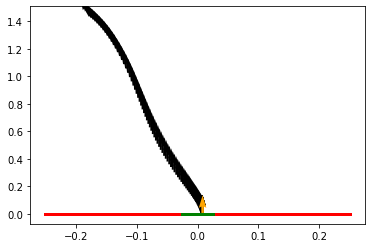

[0.00118057 0.00065241 0.00824464 0.00019014 0.00048595 0.00035463]


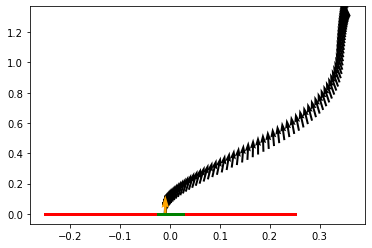

[0.00057616 0.0001099  0.00958623 0.00049132 0.00044749 0.00076171]


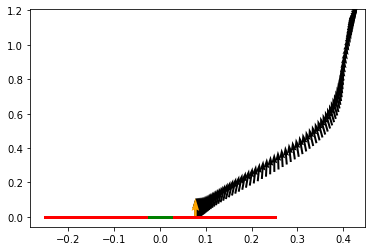

[0.00279344 0.00084155 0.07733081 0.00484228 0.00024846 0.00103925]


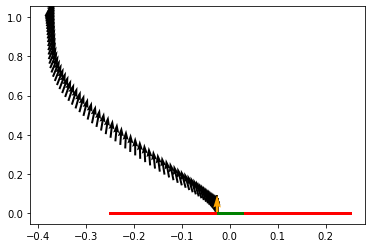

[9.1733685e-04 3.3211993e-04 2.6562033e-02 1.1894467e-04 8.6106546e-04
 8.8399720e-05]


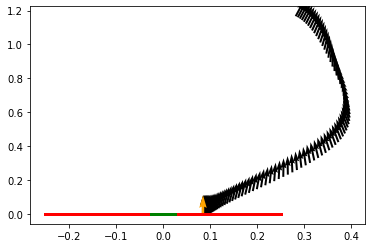

[5.4484117e-03 1.0999880e-03 8.4928967e-02 6.3939095e-03 7.5459479e-06
 1.4212881e-03]


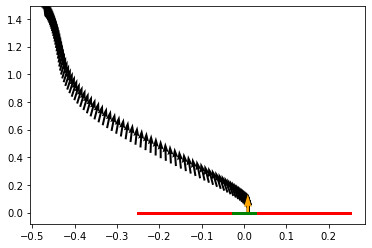

[0.00073741 0.00317118 0.00899018 0.00116327 0.00334454 0.00426288]


In [672]:
# Test the control model by some new samples:

N_eval = 10 # number of initial states for testing
d_eval = Dynamics()  # define dynamics
model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output) # define controller

path = './Landing_Model.pth' # load model
model_eval.load_state_dict(t.load(path))
model_eval.eval()
print(N_eval)
s_eval = Simulation(model_eval, d_eval, T, N_eval )
eva = Evaluation(s_eval)  # initial evaluation simulator
eva.test(N_eval) # Test